# Lab 1 - Dimensionality Reduction
## Machine Learning II

Moisés Alfonso Guerrero Jiménez

In [1]:
# Modules
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.datasets import load_digits # MNIST dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA as skl_pca
from sklearn import metrics

from PIL import Image

# Importing SVD implemented module
from unsupervised.dim_red.SVD import SVD
from unsupervised.dim_red.PCA import PCA

### Workshop I
1. Simulate a random rectangular matrix A
    - What is the rank and trace of A?
    - What is the determinant of A?
    - Can you invert A? How?
    - How are eigenvalues and eigenvectors of A'A and AA' related? What interesting differences can you notice between both?
    - See [https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf)

**R/** For simulating a rectangular matrix $A$ with dimensions $m\times n$ we could specify inputs for dimensions $m$ and $n$. For this exercise, I will simulate matrix $A$ only with integer values by using `numpy.random.randint()`, that lets us to set lower and higher integers to include in the matrix and its dimensions $m\times n$.

In this case I will generate a square matrix with integer values between -20 and 20

In [2]:
# 1. Random matrix simulation
low = -20
high = 20
m = 6
n = 6
np.random.seed(seed=1234) # Optional: Configuring seed for pseudo-random generation
A = np.random.randint(low=low, high=high, size=(m, n))
print(f"Generating matrix A_{m}x{n} with integer values between {low} and {high}...")
print(f"A = \n{A}")

Generating matrix A_6x6 with integer values between -20 and 20...
A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]


**Rank**

Rank is defined as the number of linearly independent columns of a matrix $A \in \mathbb{R}^{m\times n}$ equals the number of linearly independent rows of the matrix.

In the case of Python it is possible to obtain the matrix rank by using `numpy.linalg.matrix_rank()`.

In [3]:
# Rank of matrix A
print(f"rank(A) = {np.linalg.matrix_rank(A)}")

rank(A) = 6


**Trace**

In the case of the trace of a square matrix $A \in \mathbb{R}^{n\times n}$ it is defined as the sum of the elements on the main diagonal. 

$$trace(A)=\sum_{i=1}^{n}{a_{ii}}$$

In python it is possible to obtain it by using `numpy.trace()`, but it is important to verify that the matrix is a square matrix to satisfy the properties:

1. $trace(A+B)=trace(A)+trace(B)\ for\ A,B \in \mathbb{R}^{n\times n}$
2. $trace(\alpha A)=\alpha trace(A),\alpha \in \mathbb{R}\ for\ A \in \mathbb{R}^{n\times n}$
3. $trace(I_{n})=n$
4. $trace(AB)=trace(BA)\ for\ A\in \mathbb{R}^{n\times k}, B\in \mathbb{R}^{k\times n}$
5. $trace(A)=trace(A^{T})$

I this case we have a square matrix so it is possible to obtain the trace by using this function.

In [4]:
print(f"A = \n{A}")
print(f"trace(A) = {np.trace(A)}")

A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]
trace(A) = -35


**Determinant**

Determinants are only defined for square matrices $A \in \mathbb{R}^{n\times n}$ we can obtain it with python by using `numpy.linalg.det()`

In [5]:
print(f"det(A) = {np.linalg.det(A)}")

det(A) = 48743889.99999994


**Invertibility of A**

The matrix $A \in \mathbb{R}^{n\times n}$ is invertible if its determinant is different from zero.

In this case we can see that it is invertible so I will obtain it with python by using `numpy.linalg.inv()`.

In [6]:
# Inverse of the matrix A
print(f"A = \n{A}")
print(f"A^-1 = \n{np.round(np.linalg.inv(A), 3)}")

A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]
A^-1 = 
[[-0.018 -0.027 -0.051 -0.023 -0.04   0.041]
 [ 0.038  0.008  0.005  0.006 -0.002 -0.024]
 [ 0.042  0.002  0.024 -0.025  0.036 -0.101]
 [ 0.054  0.027  0.024 -0.027  0.029 -0.011]
 [-0.061  0.026  0.02   0.035 -0.031  0.024]
 [ 0.035 -0.045  0.019 -0.014  0.002 -0.059]]


We can check it by using the property $AA^{-1} = I_{n}$

In [7]:
# Matrix multiplication of A and A^-1
print(f"A*A^-1 = \n{np.round(np.matmul(A, np.linalg.inv(A)), decimals=0).astype(int)}")

A*A^-1 = 
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


**Eigenvalues and eigenvectors of $AA^{T}$ and $A^{T}A$**

**R/** The eigenvalues of $AA^{T}$ and $A^{T}A$ are non-negative real numbers and they are related by the singular values of the original matrix $A$. Specifically, if $\lambda$ is an eigenvalue of $AA^{T}$ or $A^{T}A$, then $\sqrt{\lambda}$ is a singular value of A.

Aditionally, $AA^{T}$ and $A^{T}A$ are related to each other through the relationship between left and right singular vectors of $A$. Specifically, if $\vec{u}$ is an eigenvector of $AA^{T}$ corresponding to the eigenvalue $\sigma$, then $\vec{v}$ is corresponding eigenvector of $A^{T}A$ with the same eigenvalue $\sigma$.

2. Add a steady, well-centered picture of your face to a shared folder alongside your classmates.
    - Edit your picture to be 256x256 pixels, grayscale (single channel).
    - Plot your edited face
    - Calculate and plot the average face of the cohort
    - How distant is your face from the average? How would you measure it?

**R/** It is necessary to specify input and output directories where images will be located, for that I will include a config file with name `lab1_config.json` in local directory with parameters specified.

**Note\*:** By default configured directories are also included in `.gitignore` file to avoid them to be included on the main repo.

In [8]:
# Reading configuration file
file = "lab1_config.json"
config_file = open(file)
config = json.load(config_file)
print(f"config file = \n{json.dumps(config, indent=2)}")

config file = 
{
  "personal_photo_input_path": "imgs/personal/Moises_Guerrero.jpeg",
  "personal_photo_output_path": "imgs/cohort/Moises_Guerrero.jpg",
  "cohort_photos_dir": "imgs/cohort/"
}


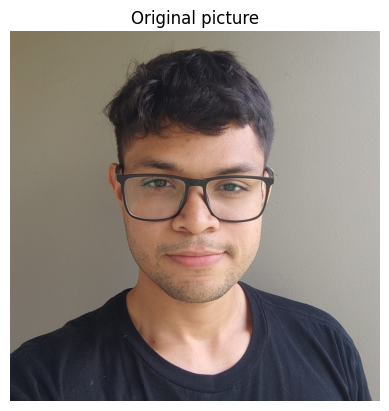

In [9]:
face_img = imread(config['personal_photo_input_path'])
# Original picture
plt.imshow(face_img)
plt.title("Original picture")
plt.axis('off')
plt.show()

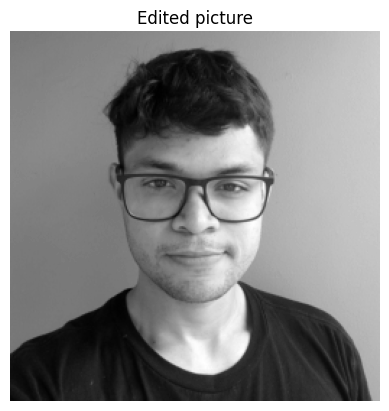

Saving edited photo in output path: 'imgs/cohort/Moises_Guerrero.jpg'...


In [10]:
# Grayscale image with 256x256 pixels
resized_img = resize(face_img, (256,256,3))
# rgb2gray function changes color scale to a float number between 0 and 1
# So I will multiplicate it by 255 and round.
grayscale_img = rgb2gray(resized_img)
grayscale_img_uint8 = np.round(255*grayscale_img).astype(np.uint8)
# Edited picture
plt.imshow(grayscale_img_uint8, cmap="gray")
plt.title("Edited picture")
plt.axis('off')
plt.show()
print(f"Saving edited photo in output path: '{config['personal_photo_output_path']}'...")
# Enable to save the edited picture
# Image.fromarray(grayscale_img_uint8).save(config['personal_photo_output_path'])

**Average face of the cohort**

For that it is necessary to read all available photos in local directory, add all of them and then divide by the number of available photos. In python it is possible to list all available photos in local directory by using `os.listdir()`.

In [11]:
faces_file_list = os.listdir(config['cohort_photos_dir'])
faces_file_list

['1.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg',
 '2.jpg',
 '20.jpg',
 '21.jpg',
 '22.jpg',
 '23.jpg',
 '24.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

Adding photo 1.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 10.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 11.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 12.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 13.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 14.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 15.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 16.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 17.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 18.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 19.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding phot

Adding photo 20.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 21.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 22.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 23.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 24.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 3.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 4.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 5.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 6.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 7.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 8.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo 9.j

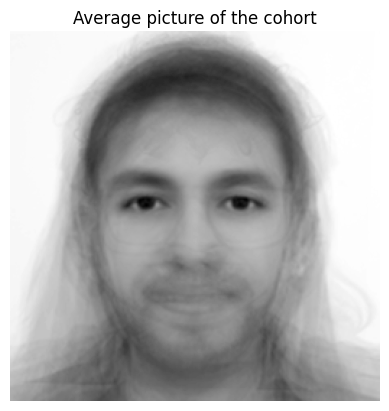

In [12]:
avg_face = np.zeros((256,256))
for face in faces_file_list:
    img = imread(os.path.join(config['cohort_photos_dir'], face)).astype(np.float64)
    print(f"Adding photo {face} with shape {img.shape}...")
    if len(img.shape) > 2:
        print("  Converting to a single channel image...")
        img = rgb2gray(img)
    avg_face += img
print("Computing average face...")
avg_face = avg_face/len(faces_file_list)
avg_face_uit8 = np.round(avg_face, decimals=0).astype(np.uint8)
print(avg_face_uit8)
plt.imshow(avg_face_uit8, cmap="gray")
plt.title("Average picture of the cohort")
plt.axis('off')
plt.show()

**Geometric distance of the face from average picture**

It is possible to calculate the distance of my face from the average by using euclidean distance between the 2 images.

$$d(A, A_{avg})=\sqrt{\sum_{i=1}^{n}{(a_{i}-av_{i})^{2}}}$$

In python it is possible to compute it by using `numpy.linalg.norm` or just applying all the formula to the arrays.

In [13]:
# Computing euclidean distance
dist = np.linalg.norm(avg_face - grayscale_img)
print(f"Distance_lin_norm = {dist}")
dist2 = np.sqrt(np.sum((avg_face-grayscale_img)**2))
print(f"Distance_formula = {dist2}")

Distance_lin_norm = 45691.83735328295
Distance_formula = 45691.83735328295


3. Let's create the unsupervised Python package
    - Same API as scikit-learn: fit(), fit_transform(), transform(), hyperparams at init.
    - Manage dependencies with Pipenv and Numpy
    - Implement SVD from scratch using Python and Numpy
    - Implement PCA from scratch using Python and Numpy [https://github.com/rushter/MLAlgorithms/blob/master/mla/pca.py, https://github.com/patchy631/machine-learning/blob/main/ml_from_scratch/PCA_from_scratch.ipynb]
    - Implement t-SNE from scratch using Python and Numpy [https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/]

In [14]:
# TODO: Finalizar el t-SNE

4. Apply SVD over the picture of your face, progressively increasing the number of singular values used. Is there any point where you can say the image is appropriately reproduced? How would you quantify how different your photo and the approximation are?

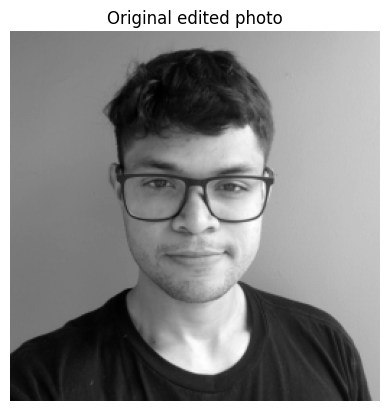

In [15]:
plt.imshow(grayscale_img, cmap='gray')
plt.title("Original edited photo")
plt.axis('off')
plt.show()

Generating test images by using my implementation of SVD using numpy...


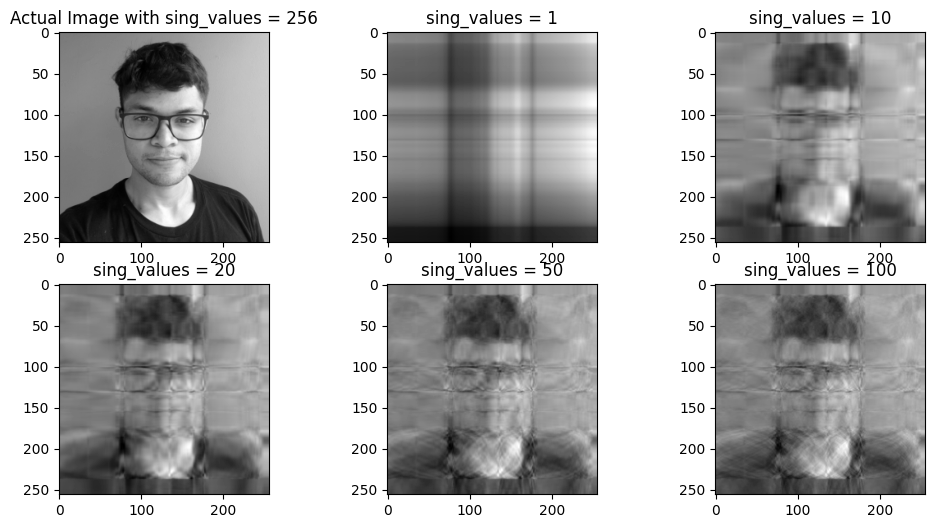

In [16]:
# Number of test to implement by using unsupervised.dim_red.SVD
svd_test = SVD()
svd_test.fit(grayscale_img)
sing_values = [len(svd_test.Sigma), 1, 10, 20, 50, 100]

plt.figure(figsize=(12, 6))
print(f"Generating test images by using my implementation of SVD using numpy...")
for i in range(len(sing_values)):
    svd_test = SVD(sing_values[i])
    transformed_img = svd_test.fit_transform(grayscale_img)
    if(i == 0): 
        plt.subplot(2, 3, i+1), 
        plt.imshow(grayscale_img, cmap='gray'), 
        plt.title(f'Actual Image with sing_values = {sing_values[i]}') 
      
    else: 
        plt.subplot(2, 3, i+1), 
        plt.imshow(transformed_img, cmap='gray'), 
        plt.title(f'sing_values = {sing_values[i]}')

Generating test images by using numpy.linalg.svd...


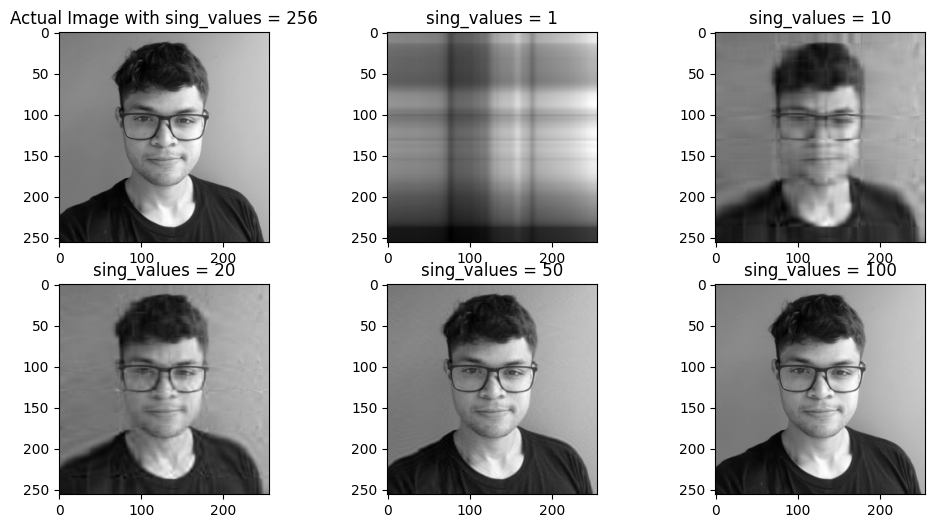

In [17]:
# Number of test to implement by using np.linalg.svd
U, S, Vt = np.linalg.svd(grayscale_img)
sing_values = [len(S), 1, 10, 20, 50, 100]

plt.figure(figsize=(12, 6))
print(f"Generating test images by using numpy.linalg.svd...")
for i in range(len(sing_values)):
    transformed_img = U[:, :sing_values[i]] @ np.diag(S[:sing_values[i]]) @ Vt[:sing_values[i], :] 
    if(i == 0): 
        plt.subplot(2, 3, i+1), 
        plt.imshow(transformed_img, cmap='gray'), 
        plt.title(f'Actual Image with sing_values = {sing_values[i]}') 
      
    else: 
        plt.subplot(2, 3, i+1), 
        plt.imshow(transformed_img, cmap='gray'), 
        plt.title(f'sing_values = {sing_values[i]}')

5. Train a naive logistic regression on raw MNIST images to distinguish between 0s and 8s. We are calling this our baseline. What can you tell about the baseline performance?

Data shape: (1797, 64)
Target shape: (1797,)


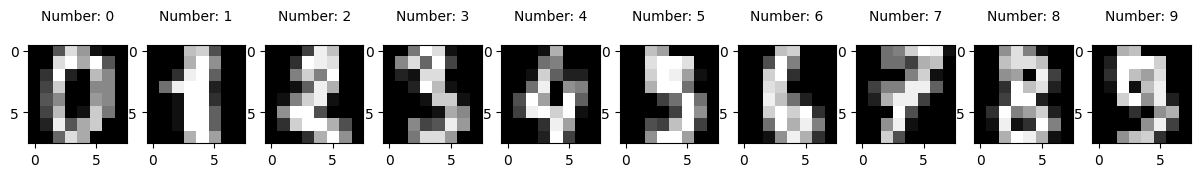

In [18]:
# Loading data
digits = load_digits()
print(f"Data shape: {digits['data'].shape}")
print(f"Target shape: {digits['target'].shape}")
plt.figure(figsize=(15,4))
for index, (image, label) in enumerate(zip(digits.data[0:10], digits.target[0:10])):
   plt.subplot(1, 10, index + 1)
   plt.imshow(np.reshape(image, (8,8)), cmap='gray')
   plt.title('Number: %i\n' % label, fontsize = 10)

In [19]:
# Selecting only 0s and 8s using pandas
# Creating a new dataframe with digits data
digits_df = pd.DataFrame(digits['data'])
# Adding target column
digits_df['target'] = digits['target']
# Filtering by 0s and 8s
digits_df_08 = digits_df[digits_df.target.isin((0, 8))]
digits_df_08

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
10,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
18,0.0,0.0,10.0,7.0,13.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,14.0,5.0,0.0,0.0,0.0,8
20,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,0.0,0.0,8.0,16.0,3.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,16.0,10.0,1.0,0.0,0.0,8
1790,0.0,0.0,5.0,12.0,8.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,12.0,12.0,3.0,0.0,0.0,8
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8


In [20]:
# Splitting data into training and test sets 
x_train, x_test, y_train, y_test = train_test_split(digits_df_08[range(0,64)].to_numpy(), 
                                                    digits_df_08['target'].to_numpy(), 
                                                    test_size=0.25, # 25% for testing
                                                    random_state=0)


In [21]:
# Creating an instance of the model
logisticRegr = LogisticRegression()
# Training the model
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [22]:
predictions = logisticRegr.predict(x_test)

In [23]:
score = logisticRegr.score(x_test, y_test)
print(score)

1.0


6. Now, apply dimensionality reduction using all your algorithms to train the model with only 2 features per image.
    - Plot the 2 new features generated by your algorithm
    - Does this somehow impact the performance of your model?

In [24]:
# Selecting only 0s and 8s using pandas
# Creating a new dataframe with digits data
digits_df = pd.DataFrame(digits['data'])
# Adding target column
digits_df['target'] = digits['target']
# Filtering by 0s and 8s
digits_df_08 = digits_df[digits_df.target.isin((0, 8))]
digits_df_08

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
10,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
18,0.0,0.0,10.0,7.0,13.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,14.0,5.0,0.0,0.0,0.0,8
20,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,0.0,0.0,8.0,16.0,3.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,16.0,10.0,1.0,0.0,0.0,8
1790,0.0,0.0,5.0,12.0,8.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,12.0,12.0,3.0,0.0,0.0,8
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8


In [25]:
# Here I'll use PCA
print(f"original_data = \n{digits_df_08[range(0,64)].to_numpy()}")
features = 2
digits_pca = PCA(features)
transformed_digits = digits_pca.fit_transform(digits_df_08[range(0, 64)].to_numpy())
digits_df_08_ = pd.DataFrame(transformed_digits)
digits_df_08_['target'] = digits_df_08['target'].to_numpy()
print(f"transformed_data = ")
digits_df_08_

original_data = 
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  9. ... 11.  1.  0.]
 [ 0.  0.  1. ...  3.  0.  0.]
 ...
 [ 0.  0.  6. ...  6.  0.  0.]
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
transformed_data = 


,0,1,target
0,17.959269,-4.657023,0
1,-16.560432,4.855184,8
2,12.520359,-0.563463,0
3,-18.154914,-21.181997,8
4,16.250911,5.134857,0
...,...,...,...
347,-25.381332,-17.178897,8
348,-25.609229,-3.493881,8
349,18.093194,-1.309088,0
350,-20.906158,2.543700,8


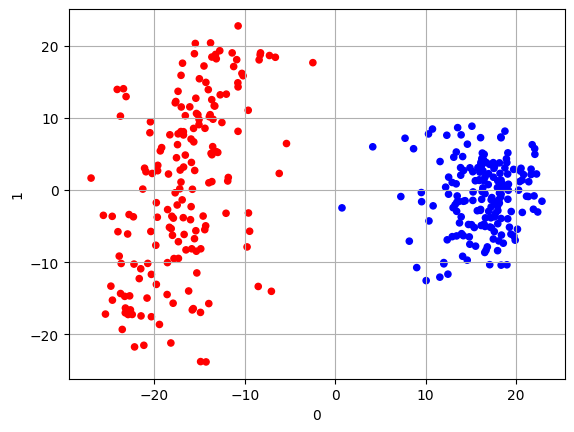

In [26]:
color = np.where(digits_df_08_['target'] == 0, 'b', np.where(digits_df_08_['target'] == 8, 'r', 'k'))
digits_df_08_.plot.scatter(x=0, y=1, c=color)
plt.plot()
plt.grid()
plt.show()

In [27]:
# Splitting data into training and test sets 
x_train, x_test, y_train, y_test = train_test_split(transformed_digits, 
                                                    digits_df_08['target'].to_numpy(), 
                                                    test_size=0.25, # 25% for testing
                                                    random_state=0)

In [28]:
# Creating an instance of the model
logisticRegr = LogisticRegression()
# Training the model
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [29]:
score = logisticRegr.score(x_test, y_test)
score

1.0

In [30]:
predictions = logisticRegr.predict(x_test)

cm = metrics.confusion_matrix(y_true=y_test, 
                         y_pred = predictions, 
                        labels = logisticRegr.classes_)

cm

array([[46,  0],
       [ 0, 42]], dtype=int64)

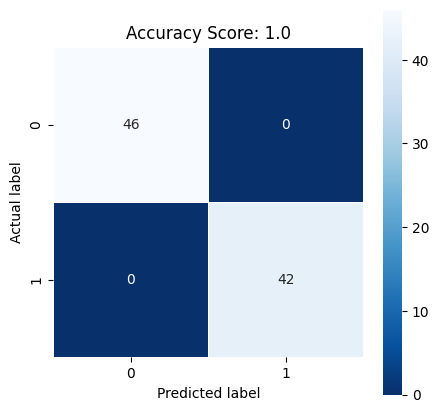

In [31]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title);

7. Repeat the process above but now using the built-in algorithms in the Scikit-Learn library. How different are these results from those of your implementation? Why?

In [32]:
print(f"original_data = \n{digits_df_08[range(0,64)].to_numpy()}")
features = 2
digits_pca = skl_pca(features)
transformed_digits = digits_pca.fit_transform(digits_df_08[range(0, 64)].to_numpy())
digits_df_08_ = pd.DataFrame(transformed_digits)
digits_df_08_['target'] = digits_df_08['target'].to_numpy()
print(f"transformed_data = ")
digits_df_08_

original_data = 
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  9. ... 11.  1.  0.]
 [ 0.  0.  1. ...  3.  0.  0.]
 ...
 [ 0.  0.  6. ...  6.  0.  0.]
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
transformed_data = 


,0,1,target
0,-17.959269,4.657023,0
1,16.560432,-4.855184,8
2,-12.520359,0.563463,0
3,18.154914,21.181997,8
4,-16.250911,-5.134857,0
...,...,...,...
347,25.381332,17.178897,8
348,25.609229,3.493881,8
349,-18.093194,1.309088,0
350,20.906158,-2.543700,8


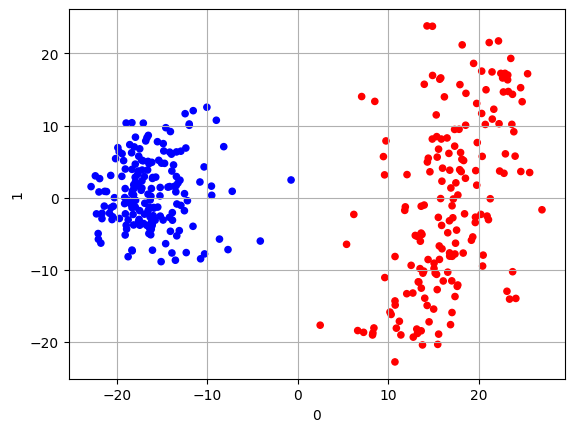

In [33]:
color = np.where(digits_df_08_['target'] == 0, 'b', np.where(digits_df_08_['target'] == 8, 'r', 'k'))
digits_df_08_.plot.scatter(x=0, y=1, c=color)
plt.grid()
plt.show()

In [34]:
# Splitting data into training and test sets 
x_train, x_test, y_train, y_test = train_test_split(transformed_digits, 
                                                    digits_df_08['target'].to_numpy(), 
                                                    test_size=0.25, # 25% for testing
                                                    random_state=0)

In [35]:
# Creating an instance of the model
logisticRegr = LogisticRegression()
# Training the model
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [36]:
score = logisticRegr.score(x_test, y_test)
score

1.0

In [37]:
predictions = logisticRegr.predict(x_test)

cm = metrics.confusion_matrix(y_true=y_test, 
                         y_pred = predictions, 
                        labels = logisticRegr.classes_)

cm

array([[46,  0],
       [ 0, 42]], dtype=int64)

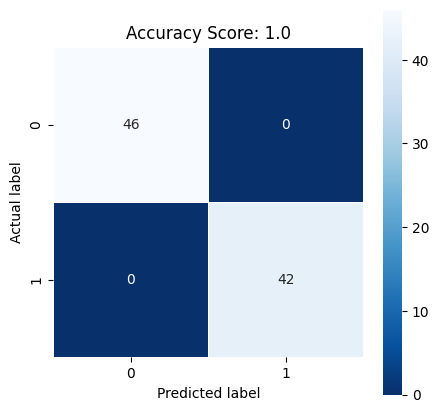

In [38]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title);

8. What strategies do you know (or can think of) in order to make PCA more robust? (Bonus points for implementing them)

**R/** According to what is implemented in https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb, there is a modification of PCA known as Robust PCA (RPCA) that factors a matrix into the sum of 2 matrices, $M=L+S$ where $M$ is the original matrix, $L$ is "low rank" and $S$ is Sparse.

"Low rank" means that the array has a lot of redundant information and "Sparse" means that the array has many values ​​that are 0.

Robust PCA (RPCA) is a variant of Principal Component Analysis (PCA) that addresses the issue when data may be corrupted by outliers or noise. Instead of assuming that the data is entirely linear and noise-free, RPCA decomposes a given matrix into the sum of two components:

Low-Rank Matrix (L), denoted as L, which represents the “true” part of the data. This matrix contains relevant and redundant information.
Sparse Matrix (S), denoted as S, which captures outliers or noise. In this matrix, many elements are zero.
The idea behind RPCA is that real data (the matrix L) can often be approximated by a low-rank matrix, while outliers or noise (the matrix S) can be modeled as a sparse matrix. The sum of these two matrices provides a more robust representation of the original data:

$M = L + S$

9. What are the underlying mathematical principles behind UMAP? What is it useful for?

**R/** UMAP (Uniform Manifold Approximation and Projection) is a nonlinear dimensionality reduction algorithm, which constructs topological representations of data in both the original dimension and low dimension. In the case of high-dimensional data, the topological structure seeks to approximate a *"Manifold"* on which the data is located. The topological representation of low-dimensional data starts with random values. Once the topological representations of the high- and low-dimensional data have been constructed, the position of the low-position points is optimized to minimize the cross entropy between the topological representations of the high- and low-dimensional data.

Consider a point $x_{i}\in \mathcal{M}$, where $\mathcal{M}$ is the *Manifold* on which the points are supposed to lie. We further consider $\mathcal{B}$ as a sphere of radius $r$ centered at $x_{i}$. The approximate geodesic distance within $\mathcal{B}$ is defined as:

$$d_{\mathcal{M}}(x_{i}, x_{j}) = \frac{1}{r_{B}}d_{\mathcal{R}^{n}}(x_{i},x_{j})$$

Where $r_{B}$ is the radius measured in the space containing $\mathcal{M}$ of $\mathcal{B}$ centered on $x_{i}$ containing the k nearest neighbors of $ x_{i}$, and $d_{\mathcal{R}^{n}}$ is the distance measure inherited from the space containing the *Manifold*.

To combine the different metric spaces built around each point into a single global structure, UMAP converts each metric space into *"simplex"* fuzzy sets, which are used to construct m-dimensional objects. The following image shows the first 4 lower-dimensional simplexes.

<img src="imgs/external/simplexes.PNG"/>

10. What are the underlying mathematical principles behind LDA? What is it useful for?

In [39]:
# TODO: Do the exercise

11. Use your unsupervised Python package as a basis to build an HTTP server that receives a record as input and returns the class of the image. Suggestions: MNIST digit classifier, Iris classifier...